In [5]:
from pymongo import MongoClient
from pymongo import ASCENDING, DESCENDING
from bson.json_util import dumps
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
plt.style.use('seaborn')
%matplotlib inline

In [6]:
#client = MongoClient('54.166.108.196:27017')
client = MongoClient('54.89.214.102:27017')
#client = MongoClient('localhost:27017')
collection = client.gdelt.events

In [3]:
monthyear = 201705

keep_fields = {'_id': False, 'day': True, 'actor1.name': True, 'actor2.name': True, 'goldsteinScale': True,
               'numMentions': True, 'numSources': True, 'numArticles': True, 'avgTone': True, 'sourceurl': True}

#lstCountry = ['FRA', 'GBR', 'DEU', 'USA', 'ISR', 'CHN', 'IRN', 'RUS'] #, 'PRK', 'PAK', 'KOR', 'SYR']

lstCountry = ['FRA', 'GBR', 'USA', 'ISR', 'CHN', 'IRN', 'RUS']

In [7]:
# Compter le nombre d'événement pendant le mois de Mai
eventCount = collection.find({'monthyear': monthyear}).count()
eventCount

5704549

In [11]:
# Evénement le plus mentionnés aprés son apparition
# NumMentions: (integer) This  is  the  total  number  of  mentions of  this  event  across  all  source
# documents during the 15 minute update in which it was first seen
buzzeventC = collection.find(
    {'monthyear': monthyear, 'isRootEvent': 1}, keep_fields).sort('numSources', DESCENDING).limit(1)

print('L''événement le plus mentionnés aprés son apparition: ')
pprint(buzzeventC.next())

print('L''événement le moins mentionnés aprés son apparition: ')
#unBuzzeventC = collection.find({'monthyear': 201705, 'isRootEvent': 1}, keep_fields).sort('numMentions', 1).limit(1)
unBuzzeventC = collection.find(
    {'monthyear': monthyear, 'isRootEvent': 1}, keep_fields).sort('numSources', 1).limit(1)
pprint(unBuzzeventC.next())

Lévénement le plus mentionnés aprés son apparition: 
{'actor1': {'name': 'UNITED STATES'},
 'avgTone': -1.6427971124649048,
 'day': 20170512,
 'goldsteinScale': 0.0,
 'numArticles': 191,
 'numMentions': 214,
 'numSources': 61,
 'sourceurl': 'http://thetandd.com/news/national/govt-and-politics/the-latest-trump-denies-collusion-between-campaign-russia/article_f2c887c8-c29f-59e7-ad41-dbf21e3217fc.html'}
Lévénement le moins mentionnés aprés son apparition: 
{'actor1': {'name': 'MOSHE YAALON'},
 'actor2': {'name': 'ISRAEL'},
 'avgTone': 2.030456781387329,
 'day': 20170501,
 'goldsteinScale': 4.0,
 'numArticles': 2,
 'numMentions': 2,
 'numSources': 1,
 'sourceurl': 'http://www.jpost.com/Breaking-News/Israel-to-come-to-standstill-with-11-am-Memorial-Day-siren-489453'}


In [12]:
# GoldsteinScale.(floating point)
# Each CAMEO event code is assigned a numeric score from -10 to +10, 
# capturing the theoretical potential impact that type of event will have on the stability of a country
#
print('L''événement ayant le plus d''impact sur la stabilité de sa région: ')

maxGoldsteinScaleEvent = collection.find(
    {'monthyear': 201705, 'isRootEvent': 1}, keep_fields).sort('goldsteinScale', DESCENDING).limit(1)
pprint(dumps(maxGoldsteinScaleEvent))

Lévénement ayant le plus dimpact sur la stabilité de sa région: 
('[{"day": 20170501, "goldsteinScale": 10.0, "numMentions": 4, "numSources": '
 '1, "numArticles": 4, "avgTone": 2.6422765254974365, "sourceurl": '
 '"http://www.cbc.ca/news/canada/newfoundland-labrador/hubert-furey-storyteller-book-1.4088426", '
 '"actor1": {"name": "CANADA"}}]')


In [13]:
# AvgTone.(numeric) This is the average “tone” of all documents containing one or more 
# mentions  of  this  event during  the  15  minute  up date  in  which  it  was  first  seen
# .    The  score ranges  from -100  (extremely  negative)  to  +100  (extremely  positive).
# Common  values  range between -10  and  +10,  with  0  indicating  neutral.
#
minAvgToneEvent = collection.find(
    {'monthyear': 201705, 'isRootEvent': 1}, keep_fields).sort('avgTone', ASCENDING).limit(1)

pprint(minAvgToneEvent.next())

maxAvgToneEvent = collection.find(
    {'monthyear': 201705, 'isRootEvent': 1}, keep_fields).sort('avgTone', DESCENDING).limit(1)

pprint(maxAvgToneEvent.next())

{'actor2': {'name': 'ENGINEER'},
 'avgTone': -38.88888931274414,
 'day': 20170513,
 'goldsteinScale': -2.0,
 'numArticles': 10,
 'numMentions': 10,
 'numSources': 1,
 'sourceurl': 'http://www.kcra.com/article/engineer-in-deadly-philadelphia-amtrak-crash-charged-with-causing-catastrophe-involuntary-manslaughter/9647571'}
{'actor1': {'name': 'SAUDI ARABIA'},
 'avgTone': 24.615385055541992,
 'day': 20170509,
 'goldsteinScale': 3.4000000953674316,
 'numArticles': 8,
 'numMentions': 8,
 'numSources': 1,
 'sourceurl': 'http://saudigazette.com.sa/saudi-arabia/makkah-award-winners-honored/'}


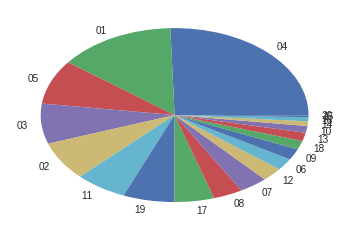

In [62]:
# Répartition

cursorEvents = collection.aggregate(
    [{'$match': {'eventRootCode': {'$ne': None}}}, {'$group': {'_id': '$eventRootCode', 'count': {'$sum': 1}}}, {'$sort': {'count': -1}}])

eventRootCodeCount = list(cursorEvents)
labels = [event['_id'] for event in eventRootCodeCount]
frac = [event['count'] for event in eventRootCodeCount]
pie = plt.pie(frac,labels=labels)

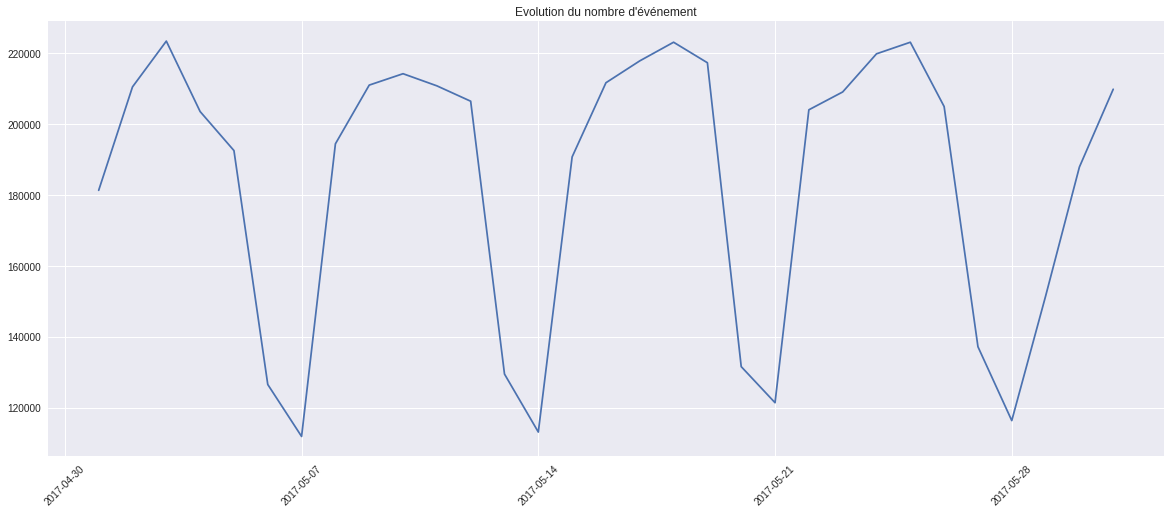

In [40]:
cursorEvents = collection.aggregate(
    [{'$match': {'monthyear': 201705}}, {'$group': {'_id': '$day', 'count': {'$sum': 1}}}, {'$sort': {'_id': -1}}])

events = list(cursorEvents)
df = pd.DataFrame(events, columns=['_id', 'count']).set_index(['_id'])

df.index = pd.to_datetime(df.index, format='%Y%m%d')
plt.figure(figsize=(20, 8))
plt.title("Evolution du nombre d'événement")
plt.xticks(rotation=45)
plt.plot(df)
plt.show()

In [134]:
import folium


data = list(collection.find({'day': 20170504, 'actionGeo.coordinates.0': {
            '$ne': None}, 'actionGeo.fullname': {
            '$ne': None}}, {'actionGeo.coordinates': True, 'actionGeo.fullname': True}))

fullnames = [row.get('actionGeo').get('fullnames') for row in data]
coordinates = [row.get('actionGeo').get('coordinates') for row in data]

map = folium.Map(location=[38.9, -77.05], zoom_start=12)

for point in range(0, len(coordinates[0:1000])):
    folium.Marker(coordinates[point],
                  popup=fullnames[point]).add_to(map)

map

In [ ]:
client.close();